In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import random_split
import torch.nn.functional as F
#import torch.optim as optim

import pandas as pd
import seaborn as sns


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

testvalset = torchvision.datasets.CIFAR10(root='./data/', train=False,
                                          download=False, transform=transform)

testset, valset = random_split(testvalset, [0.5, 0.5])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

print(len(trainset))
print(len(testset))
print(len(valset))

# print(len(dataset))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
50000
5000
5000


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [4]:

from NNs import init_weights, CNN

model = CNN().to(device)
model.apply(init_weights)

CNN(
  (InputDropout): Dropout(p=0.2, inplace=False)
  (ConvBlock1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ConvBlock2): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (PoolBlock1): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (ConvBlock3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ConvBlock4): Sequential(
    (0): Conv2d(192, 192, kerne

In [5]:
#print_output_shape = False


#data_iter = iter(trainset)

#for i in range(3):
    #(data, label) = next(data_iter)
#im = data
#data = data.unsqueeze(0)
#input_shape = data.shape

#if (print_output_shape):
    #print(data.shape)
    #print(model(data))
    #print('\n')


#from torchsummary import summary
#_ = summary(model, ( 3, 32, 32))

#print(model(data).shape)

In [6]:
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.97)


In [7]:
#epoch_number = 75
#epoch_number = 130
epoch_number = 200 

from Helper_Functions import calculate_valloss, calculate_accuracy, save_checkpoint


epoch_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []
epoch_range_list = list(range(epoch_number))


for epoch in range(epoch_number):  # loop over the dataset multiple times
    n_batches = 0
    running_loss = 0.0


    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
       
        outputs = model(inputs)
        #print(outputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        n_batches += 1

    epoch_list.append(epoch+1)
    loss_list.append(running_loss/n_batches)
    
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / n_batches:.7f}')
    running_loss = 0.0

    val_accuracy_list.append(calculate_accuracy(model, valloader, device))
    val_loss_list.append(calculate_valloss(model, criterion, valloader, device))


    if (epoch+1) % 5 == 0:
        save_checkpoint(model, optimizer, epoch+1, loss.item(), filename=f"checkpoints/checkpoint_{epoch + 1}.pth")
        

    scheduler.step()


print('Finished Training')

[1,   391] loss: 1.7749029
[2,   391] loss: 1.4335422
[3,   391] loss: 1.2391650
[4,   391] loss: 1.1148174
[5,   391] loss: 1.0264370
Checkpoint saved at epoch 5
[6,   391] loss: 0.9552659
[7,   391] loss: 0.8867356
[8,   391] loss: 0.8369284
[9,   391] loss: 0.7947256
[10,   391] loss: 0.7579570
Checkpoint saved at epoch 10
[11,   391] loss: 0.7271301
[12,   391] loss: 0.6964714
[13,   391] loss: 0.6715807
[14,   391] loss: 0.6482149
[15,   391] loss: 0.6294228
Checkpoint saved at epoch 15
[16,   391] loss: 0.6126885
[17,   391] loss: 0.5954578
[18,   391] loss: 0.5761977
[19,   391] loss: 0.5660980
[20,   391] loss: 0.5488663
Checkpoint saved at epoch 20
[21,   391] loss: 0.5358803
[22,   391] loss: 0.5220298
[23,   391] loss: 0.5098112
[24,   391] loss: 0.4960596
[25,   391] loss: 0.4887406
Checkpoint saved at epoch 25
[26,   391] loss: 0.4763622
[27,   391] loss: 0.4648873
[28,   391] loss: 0.4536252
[29,   391] loss: 0.4439088
[30,   391] loss: 0.4339867
Checkpoint saved at epoch

Text(0.5, 1.0, 'Training Loss')

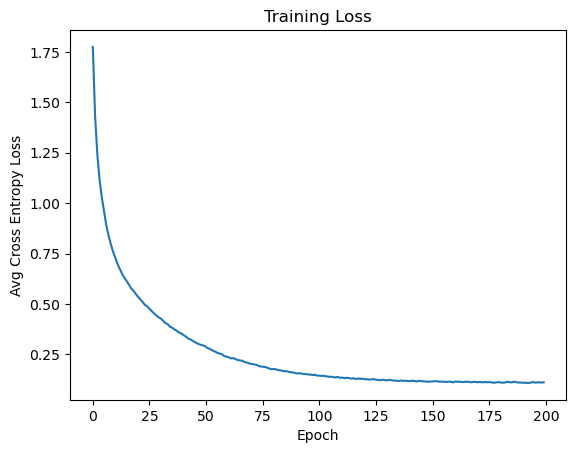

In [8]:
dic = {'losses':loss_list, 'epoch':epoch_list}
df = pd.DataFrame(data=dic)
#df = df[150:]

p = sns.lineplot(data=df, x=df.index, y='losses')
p.set_xlabel("Epoch")
p.set_ylabel("Avg Cross Entropy Loss")
p.set_title("Training Loss")


Text(0.5, 1.0, 'Validation Accuracy per Epoch')

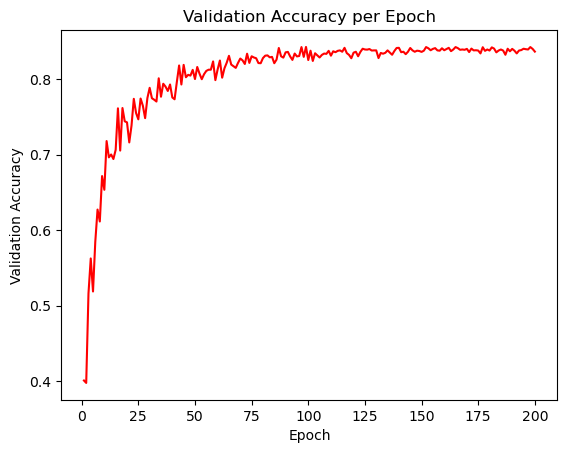

In [9]:
dic2 = {'Validation Accuracy':val_accuracy_list, 'Epoch':epoch_list}
df2 = pd.DataFrame(data=dic2)

p2 = sns.lineplot(data=df2, x='Epoch', y='Validation Accuracy', color='red')
p2.set_title('Validation Accuracy per Epoch')



[0.04872346669435501, 0.034619297832250595, 0.02484811469912529, 0.03715892508625984, 0.02986413799226284, 0.021683339029550552, 0.019466673955321312, 0.034606095403432846, 0.031373750418424606, 0.01743336021900177, 0.02085217274725437, 0.04548083618283272, 0.02146872878074646, 0.012321441434323788, 0.015576553530991077, 0.014119543135166168, 0.015553290024399757, 0.025129616260528564, 0.01673826389014721, 0.04288266599178314, 0.02995867095887661, 0.015632616356015205, 0.026834895834326744, 0.012084638699889183, 0.011277591809630394, 0.01020283903926611, 0.019738877192139626, 0.008423830382525921, 0.005217121914029121, 0.001290169428102672, 0.025127142667770386, 0.03194994479417801, 0.015535046346485615, 0.004792732186615467, 0.019152585417032242, 0.014657648280262947, 0.019128654152154922, 0.0037786313332617283, 0.018263420090079308, 0.02200441248714924, 0.008062263019382954, 0.01557942945510149, 0.03295886889100075, 0.01579555869102478, 0.005117199849337339, 0.004421495366841555, 0.0

Text(0.5, 1.0, 'Validation Accuracy per Epoch')

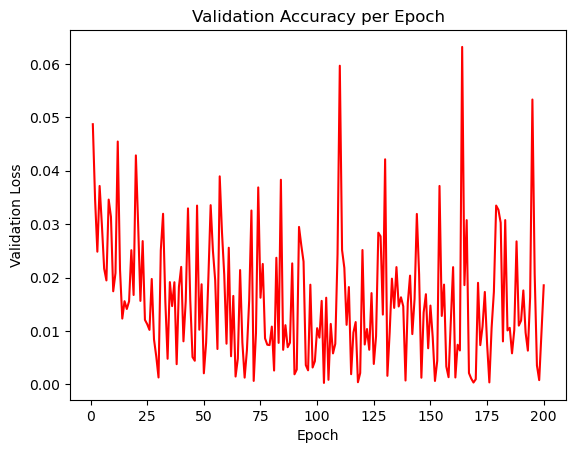

In [ ]:
val_loss_list_tensor = [float(x) for x in val_loss_list]
print(val_loss_list_tensor)

dic3 = {'Validation Loss':val_loss_list_tensor, 'Epoch':epoch_list}
df3 = pd.DataFrame(data=dic3)

p3 = sns.lineplot(data=df3, x='Epoch', y='Validation Loss', color='red')
p3.set_title('Validation Loss per Epoch')

In [ ]:
test_single_image = False

if (test_single_image):
    data_iter = iter(testset)

    for i in range(40):
        (data, label) = next(data_iter)
    im = data
    data = data.unsqueeze(0)
    soft = nn.Softmax(dim=1)
    imshow(im)
    print(label)

    model_output = model(data)
    prediction = soft(model_output)

    _, ind = (torch.max(prediction, dim=1))
    print(ind)
    print("\n")

#from torchviz import make_dot, make_dot_from_trace
#make_dot(model_output.mean(), params=dict(model.named_parameters()))




In [15]:

calculate_accuracy(model, testloader, device)


0.8438

### Code to save Model

In [ ]:
#torch.save(model.state_dict(), "model_weights_130_epochs")